# Points

In [65]:
from pathlib import Path
import json

import shapely
import shapely.wkt
import shapely.geometry.point
import pandas

In [5]:
adresace = pandas.read_csv('teplarny-adresace.csv', sep=';')

In [10]:
print(len(adresace))
adresace.head()

1361


,Adresa,Adresa interní,Městská část,GPS lat,GPS lon,vyska,Typ zdroje,Systém,Popis
0,Absolonova 26a,PKK1 Absolonov.26a,Komín,49.219944,16.557275,214.6,PK,K1AbsKOT,Kotle K1 Absolonova
1,Absolonova 26a,PKK1 Absolonov.26a,Komín,49.219944,16.557275,214.6,PK,K1AbsSTR,Topení K1 Absolonova
2,Absolonova 26a,PKK1 Absolonov.26a,Komín,49.219944,16.557275,214.6,PK,K1AbsMT,Měření K1 Absolonova
3,Absolonova 26a,PKK1 Absolonov.26a,Komín,49.219944,16.557275,214.6,PK,K1AbsPS1,"14-16,18-20,22-24,26-28"
4,Absolonova 26a,PKK1 Absolonov.26a,Komín,49.219944,16.557275,214.6,PK,AbsPS1MT,"14-16,18-20,22-24,26-28"


In [12]:
gps_to_addr = adresace[['GPS lat', 'GPS lon', 'Adresa']].set_index(['GPS lat', 'GPS lon']).drop_duplicates()
len(gps_to_addr)

468

In [13]:
gps_to_addr.head()

,,Adresa
GPS lat,GPS lon,
49.219944,16.557275,Absolonova 26a
49.221424,16.555999,Absolonova 93a
49.225195,16.627615,Arbesova 12
49.188868,16.536241,Axmanova 12a
49.183984,16.600925,"Bakalovo nábřeží 1,2"


# Greenery

In [20]:
shapes = {}
out_dir = Path('shapes')
for path in out_dir.glob('*.wkt'):
    wkt = path.read_text()
    shapes[path.stem] = shapely.wkt.loads(wkt)

In [22]:
shapes

{'allotments': <shapely.geometry.multipolygon.MultiPolygon at 0x7f46bf28fe48>,
 'cemetery': <shapely.geometry.multipolygon.MultiPolygon at 0x7f46bf263208>,
 'commercial': <shapely.geometry.multipolygon.MultiPolygon at 0x7f46bf28f828>,
 'farm': <shapely.geometry.multipolygon.MultiPolygon at 0x7f46bf28f3c8>,
 'forest': <shapely.geometry.multipolygon.MultiPolygon at 0x7f46bf263668>,
 'grass': <shapely.geometry.multipolygon.MultiPolygon at 0x7f46bf28f518>,
 'heath': <shapely.geometry.multipolygon.MultiPolygon at 0x7f46bf28f6d8>,
 'industrial': <shapely.geometry.multipolygon.MultiPolygon at 0x7f46bf28f9e8>,
 'meadow': <shapely.geometry.multipolygon.MultiPolygon at 0x7f46bf263eb8>,
 'military': <shapely.geometry.multipolygon.MultiPolygon at 0x7f46bf277828>,
 'nature_reserve': <shapely.geometry.multipolygon.MultiPolygon at 0x7f46bf28f048>,
 'orchard': <shapely.geometry.multipolygon.MultiPolygon at 0x7f46bf2634a8>,
 'park': <shapely.geometry.multipolygon.MultiPolygon at 0x7f46bf28f278>,
 'quar

In [51]:
target_shape = shapes['park'].union(shapes['forest'])

In [69]:
with Path('target_shape.json').open('w') as f:
    json.dump(shapely.geometry.mapping(target_shape), f)

# Point data

In [50]:
radiuses = 0.001, 0.005, 0.01
pts = pandas.DataFrame(columns=radiuses, index=gps_to_addr.index, dtype=float)
pts.sort_index()
pts.head()

,,0.001,0.005,0.01
GPS lat,GPS lon,,,
49.219944,16.557275,NaN,NaN,NaN
49.221424,16.555999,NaN,NaN,NaN
49.225195,16.627615,NaN,NaN,NaN
49.188868,16.536241,NaN,NaN,NaN
49.183984,16.600925,NaN,NaN,NaN


In [52]:
for lat, lon in pts.index:
    pt = shapely.geometry.point.Point(lon, lat)
    for radius in radiuses:
        buf = pt.buffer(radius)
        intersection = buf.intersection(target_shape)
        pts.loc[(lat, lon), radius] = intersection.area / buf.area
pts.head()

/home/pviktori/dev/brnohack/__venv__/lib64/python3.5/site-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)
/home/pviktori/dev/brnohack/__venv__/lib64/python3.5/site-packages/ipykernel/zmqshell.py:533: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


,,0.001,0.005,0.01
GPS lat,GPS lon,,,
49.219944,16.557275,0.000000,0.006768,0.089513
49.221424,16.555999,0.000000,0.000014,0.075922
49.225195,16.627615,0.476345,0.552731,0.427979
49.188868,16.536241,0.224494,0.429830,0.379868
49.183984,16.600925,0.349685,0.062003,0.054482


In [55]:
pts.describe()

,0.001,0.005,0.01
count,468.000000,468.000000,468.000000
mean,0.060158,0.083184,0.110503
std,0.158464,0.128271,0.114249
min,0.000000,0.000000,0.000000
25%,0.000000,0.013646,0.040991
50%,0.000000,0.035065,0.072484
75%,0.001194,0.078132,0.129324
max,0.834338,0.699118,0.705347


In [56]:
Path('points.csv').write_text(pts.to_csv())

34482

0.0003136548490546016


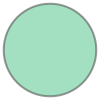

In [61]:
print(buf.area)
buf

4.06269032207059e-05


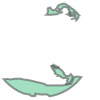

In [62]:
print(intersection.area)
intersection